In [1570]:
import numpy as np
import matplotlib.pyplot as plt

**Определение функций принадлежности**

In [1571]:
def Trapeze(x, a, b, c, d):
    return np.where(
        x <= a,
        0,
        np.where(
            (a < x) & (x < b),
            (x-a)/(b-a) if b != a else 0,
            np.where(
                (b <= x) & (x <= c),
                1,
                np.where(
                    (c < x) & (x < d),
                    (d-x)/(d-c) if d != c else 0,
                    0
                )
            )
        )
    )

def Triangle(x, a, b, c):
    return np.where(
        x <= a,
        0,
        np.where(
            (a < x) & (x < b),
            (x-a)/(b-a) if b != a else 0,
            np.where(
                (b <= x) & (x <= c),
                (c-x)/(c-b) if c != b else 0,
                0
            )
        )
    )


**Определение классов для нечеткой системы**

In [1572]:
class Feature():
    def __init__(self, name, units, min, max, inout):
        self.name = name
        self.units = units
        self.min = min
        self.max = max
        self.inout = inout
        self.value = None
        self.rules = []

In [1573]:
class FuzzyPredicate():
    def __init__(self, feature: Feature, name, func=None, const=None):
        self.feature: Feature = feature
        self.name = name
        self.func = func  # Сохраняем функцию, а не результат ее вызова
        self.const = const

    def scalar(self,x=None):
        if x is None:
            if self.const is None:
                raise ValueError(f"Const value for predicate {self.feature.name} '{self.name}' is not specified!")
            else:
                return self.const

        if self.func is None:
            raise ValueError(f"Function for predicate {self.feature.name} '{self.name}' is not specified!")

        return self.func(x)  # Вызываем функцию с аргументом x


In [1574]:
class Rule():
    def __init__(self, input_pridicates, output_pridicate, weight):
        self.inputs = input_pridicates
        self.output = output_pridicate
        self.weight=weight
        self.truth = None

In [1575]:
class Mamdani():
    def __aggregation__(fis):
        for rule in fis.rules:
            inputs = rule.inputs
            rule.truth=min([input.scalar(input.feature.value) for input in inputs])

    def __activation__(fis):
        for rule in fis.rules:
            rule.truth = rule.truth*rule.weight

    def calculate(fis):
        Mamdani.__aggregation__(fis)
        Mamdani.__activation__(fis)

        result = []
        for feature_out in fis.features_out:
            rules = feature_out.rules
            if len(rules)==0:
                print(f"There is no rules for target feature: {feature_out.name}")
                result.append(np.nan)
                continue

            numerator = 0
            denominator = 0
            if fis.defuzzyfication=="Centroid":
                xarr = feature_out.linspace
                for x in xarr:
                    y = max([min(rule.output.scalar(x), rule.truth) for rule in rules])
                    numerator += x*y
                    denominator += y
            elif fis.defuzzyfication=="Simple":
                for rule in rules:
                    numerator += rule.output.scalar()*rule.truth
                    denominator += rule.truth

            if denominator!=0:
                result.append(numerator/denominator)
            else:
                result.append(np.nan)
        return result

In [1576]:
class FuzzyInferenceSystem():
    def __init__(self):
        self.features_in = []
        self.features_out = []
        self.rules = []
        self.algorithm="Mamdani"
        self.defuzzyfication="Centroid"
        self.num = 100

    def create_feature(self, name, units, min, max, inout):
        feature = Feature(name, units, min, max, inout)
        if inout:
            self.features_in.append(feature)
        else:
            feature.linspace = np.linspace(feature.min, feature.max, self.num)
            self.features_out.append(feature)
        return feature

    def create_predicate(self, feature: Feature, name, func=None, const=None):
        predicate = FuzzyPredicate(feature, name, func, const)
        return predicate

    def create_rule(self, input_pridicates, output_pridicate, weight):
        rule = Rule(input_pridicates, output_pridicate, weight)
        self.rules.append(rule)
        output_pridicate.feature.rules.append(rule)
        return rule

    def predict(self,*x):
        if (self.algorithm=='Mamdani'):
            print(Mamdani.calculate(self))
            return Mamdani.calculate(self)
        else:
            raise Exception("Supported values for paramether 'algorithm' are 'Mamdani'.")


**Создание нечеткой системы**

In [1577]:
fis = FuzzyInferenceSystem()
fis.algorithm = 'Mamdani'
fis.defuzzyfication = "Centroid"

**Создание признаков**

In [1578]:
f_temp = fis.create_feature("Температура", "C", -10, 35, True)
f_humidity = fis.create_feature("Влажность", "%", 0, 100, True)
f_pressure = fis.create_feature("Давление", "hPa", 970, 1040, True)
f_wind_speed = fis.create_feature("Скорость ветра", "м/с", 0, 50, True)
f_weather = fis.create_feature("Погода", "", 0, 4, False)

**Создание предикатов(Выбрал средние значения определенного региона: Амстердам, Нидерланды)**

In [1579]:
p_temp_low = fis.create_predicate(f_temp, 'низкая', func=lambda x: Trapeze(x, -10, -10, 0, 10))
p_temp_normal = fis.create_predicate(f_temp, 'средняя', func=lambda x: Triangle(x, 5, 15, 25))
p_temp_high = fis.create_predicate(f_temp, 'высокая', func=lambda x: Trapeze(x, 20, 25, 35, 35))

p_humidity_low = fis.create_predicate(f_humidity, 'низкая', func=lambda x: Trapeze(x, 0, 0, 20, 40))
p_humidity_normal = fis.create_predicate(f_humidity, 'средняя', func=lambda x: Triangle(x, 30, 60, 90))
p_humidity_high = fis.create_predicate(f_humidity, 'высокая', func=lambda x: Trapeze(x, 80, 90, 100, 100))

p_pressure_low = fis.create_predicate(f_pressure, 'низкое', func=lambda x: Trapeze(x, 970, 970, 990, 1010))
p_pressure_normal = fis.create_predicate(f_pressure, 'среднее', func=lambda x: Triangle(x, 1000, 1010, 1020))
p_pressure_high = fis.create_predicate(f_pressure, 'высокое', func=lambda x: Trapeze(x, 1020, 1030, 1040, 1040))

p_wind_speed_low = fis.create_predicate(f_wind_speed, 'малая', func=lambda x: Trapeze(x, 0, 0, 10, 20))
p_wind_speed_normal = fis.create_predicate(f_wind_speed, 'средняя', func=lambda x: Triangle(x, 15, 25, 35))
p_wind_speed_high = fis.create_predicate(f_wind_speed, 'большая', func=lambda x: Trapeze(x, 30, 35, 50, 50))


p_weather_clear = fis.create_predicate(f_weather, 'ясно', func=lambda x: 0)
p_weather_cloudy = fis.create_predicate(f_weather, 'облачно', func=lambda x: 1)
p_weather_rain = fis.create_predicate(f_weather, 'дождь', func=lambda x: 2)
p_weather_snow = fis.create_predicate(f_weather, 'снег', func=lambda x: 3)
p_weather_storm = fis.create_predicate(f_weather, 'шторм', func=lambda x: 4)


**Создание правил**

In [1580]:
# Ясная погода
fis.create_rule([p_temp_high, p_humidity_low, p_pressure_high, p_wind_speed_low], p_weather_clear, 1)

# Облачная погода
fis.create_rule([p_temp_normal, p_humidity_normal, p_pressure_normal, p_wind_speed_normal], p_weather_cloudy, 1)

# Дождливая погода
fis.create_rule([p_temp_normal, p_humidity_high, p_pressure_low, p_wind_speed_high], p_weather_rain, 1)

# Снежная погода
fis.create_rule([p_temp_low, p_humidity_high, p_pressure_low, p_wind_speed_high], p_weather_snow, 1)

# Штормовая погода
fis.create_rule([p_temp_high, p_humidity_high, p_pressure_low, p_wind_speed_high], p_weather_storm, 1)

**<span style="color:red">При создании всех возможных правил, почему то багуется и выдает всегда дождь или облачно, возможно из за того, что правила и функции принадлежности таковы, что дождь и облачно являются наиболее вероятным прогнозом для большинства входных данных...</span>**

In [ ]:
#predicates_temp = [p_temp_low, p_temp_normal, p_temp_high]
#predicates_humidity = [p_humidity_low, p_humidity_normal, p_humidity_high]
#predicates_pressure = [p_pressure_low, p_pressure_normal, p_pressure_high]
#predicates_wind_speed = [p_wind_speed_low, p_wind_speed_normal, p_wind_speed_high]
#predicates_weather = [p_weather_clear, p_weather_cloudy, p_weather_rain, p_weather_snow, p_weather_storm]

#for pred_temp in predicates_temp:
#    for pred_humidity in predicates_humidity:
#        for pred_pressure in predicates_pressure:
#            for pred_wind_speed in predicates_wind_speed:
#                for pred_weather in predicates_weather:
#                    fis.create_rule([pred_temp, pred_humidity, pred_pressure, pred_wind_speed], pred_weather, 1)
#

**Тестовые данные**

In [1581]:
test_temp = 22
test_humidity = 77
test_pressure = 1015
test_wind_speed = 27

**Установка значений входных признаков**

In [1582]:
f_temp.value = test_temp
f_humidity.value = test_humidity
f_pressure.value = test_pressure
f_wind_speed.value = test_wind_speed

#for rule in fis.rules:
#    rule.truth = min([input.scalar(input.feature.value) for input in rule.inputs])
#    print(f"Rule truth: {rule.truth}")

**Прогноз**

In [1583]:
weather_dict = {0: 'ясно', 1: 'облачно', 2: 'дождь', 3: 'снег', 4: 'шторм'}
result = fis.predict()

[1.9999999999999967]


In [1584]:
if np.isnan(result[0]):
    print("Не удалось сделать прогноз на основе входных данных")
else:
    # Используйте значение прогноза для поиска соответствующей метки погоды
    weather_forecast = weather_dict[int(result[0])]
    print(f"Прогноз погоды: {weather_forecast}")

Прогноз погоды: облачно


**Создание массива значений для оси x**

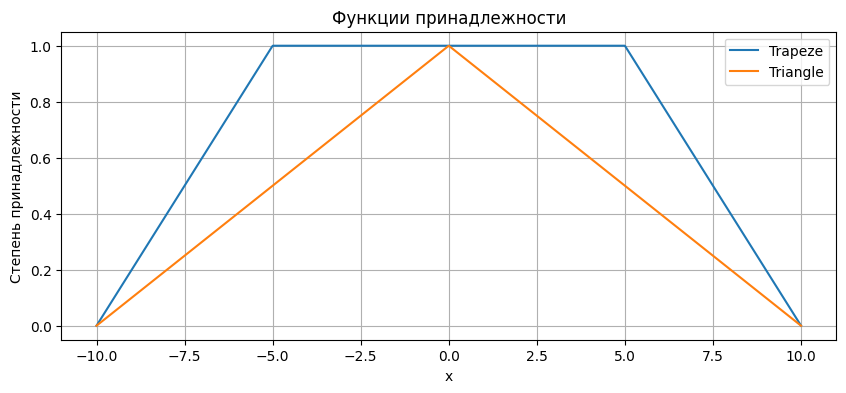

In [1585]:
x = np.linspace(-10, 10, 1000)
y_trapeze = Trapeze(x, -10, -5, 5, 10)
y_triangle = Triangle(x, -10, 0, 10)
plt.figure(figsize=(10, 4))
plt.plot(x, y_trapeze, label='Trapeze')
plt.plot(x, y_triangle, label='Triangle')
plt.title('Функции принадлежности')
plt.xlabel('x')
plt.ylabel('Степень принадлежности')
plt.legend()
plt.grid(True)
plt.show()

**Вычисление значения функций принадлежности для каждого значения x**

In [1586]:
y_temp_low = [p_temp_low.func(i) for i in x]
y_temp_normal = [p_temp_normal.func(i) for i in x]
y_temp_high = [p_temp_high.func(i) for i in x]

**Построение графика функций принадлежности**

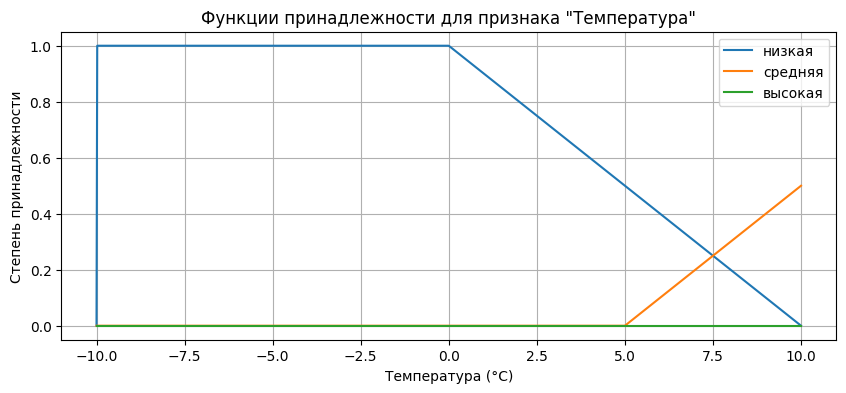

In [1587]:
plt.figure(figsize=(10, 4))
plt.plot(x, y_temp_low, label='низкая')
plt.plot(x, y_temp_normal, label='средняя')
plt.plot(x, y_temp_high, label='высокая')
plt.title('Функции принадлежности для признака "Температура"')
plt.xlabel('Температура (°C)')
plt.ylabel('Степень принадлежности')
plt.legend()
plt.grid(True)
plt.show()

**В ходе этой работы были получены знания и навыки в области нечеткой логики и систем нечеткого вывода. Были изучены и применены методы создания функций принадлежности, формулирования правил нечеткого вывода и применения этих правил для предсказания выходных данных на основе входных данных.**

**Методы, которые были применены, включают фаззификацию (преобразование входных данных в нечеткие значения), применение правил (вычисление степени истинности каждого правила), агрегацию правил (объединение степеней истинности всех правил для каждого предиката выходных данных) и дефаззификацию (преобразование нечетких выходных значений обратно в четкое значение).**

**Полученные результаты могут быть использованы для создания систем нечеткого вывода в различных областях, таких как прогнозирование погоды, управление трафиком, робототехника и многое другое. Они также могут быть использованы для дальнейшего изучения и исследования нечеткой логики и систем нечеткого вывода.**